# Non-negative Matrix Factorization

Non-negative matrix factorization (NMF) is a simple yet effective method to decompose a matrix into a product of two non-negative matrices(that is sparse matrices with all non-negative entries). This technique is most commonly used in recommender systems, and was made well known by the Netflix Prize. NMF aims to factor a data matrix $X$ into a product of two matrices:

$$X \approx AS $$

where $X$ is a $n \times m$ matrix, $A$ is a $n \times k$ matrix, and $S$ is a $k \times m$ matrix. $k$ is usually provided by the user, and symbolizes the number of distinct "factors" in the data. For example, if our data was the total productivity of a group of factories per hour for the past week, the number of factors $k$ would be the number of factories. Without prior knowledge the number of factors would be harder to pinpoint, and would have to be chosen using cross validation or something similar

It's important to note that this problem does not have a unique solution, and we could end up with many different combinations of $A$ and $S$ that multiply to get a decent approximation of $X$. Even more, each pair of $A$ and $S$ can be scaled by any real number $\alpha$ and $\frac{1}{\alpha}$ respectively to yield an infinite number of pairs. 

## Alternating Least Squares

The natural question to ask now is how to determine $A$ and $S$ when given $X$ and $k$. One relatively simple method is to use alternating least squares, which is a generalization of the least squares method for simple linear regression. In simple linear regression, the goal is to solve the following equation for $x$:

$$ Ax = b \implies A^TAx = A^Tb \implies x = (A)^{\dagger}b\$$

This can be generalized for a product of matrices by picking a random $i^{th}$ column of $X$ and $S$, which we will denote $x_{:,i}$ and $s_{:,i}$, fixing $A$, and solving for $s_{:,i}$. Then by our previous equation $X \approx AS$ we have 

$$ x_{:,i} \approx As_{:,i}$$
This yields the following update rule:

$$ s_{:,i} := (A)^{\dagger}x_{:,i}$$

However, since we also want to solve for $A$ we need to sample a column of $A$ and fix $S$. To get the same linear form we do the following:

$$x_{i,:} \approx a_{i,:}S \implies x_{i,:}^T \approx S^Ta_{i,:}^T$$

We switch to updating the rows of $A$ rather than the columns due to dimensionality, and get the following update rule:

$$ a_{i,:}^T = (SS^T)^{-1}Sx_{i,:}^T $$

We then repeat these updates until convergence or the number of iterations is fulfilled. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

np.set_printoptions(suppress=True)

In [3]:
np.random.seed(1)
col1 = np.array([[0, 0, 9, 5, 3, 2, 1, 0, 0, 0, 0, 0]])
col2 = np.array([[0, 0, 0, 0, 0, 3, 2, 1, 1, 0, 0, 0]])
col3 = np.array([[0, 5, 5, 6, 6, 7, 4, 2, 1, 0.5, 0, 0]])

factors = np.vstack((col1, col2, col3)).T
weights = np.random.randint(0, 2, size=(3, 10))

X = np.matmul(factors, weights)
print(X)
print(factors)
print(weights)

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[0.  0.  0. ]
 [0.  0.  5. ]
 [9.  0.  5. ]
 [5.  0.  6. ]
 [3.  0.  6. ]
 [2.  3.  7. ]
 [1.  2.  4. ]
 [0.  1.  2. ]
 [0.  1.  1. ]
 [0.  0.  0.5]
 [0.  0.  0. ]
 [0.  0.  0. ]]
[[1 1 0 0 1 1 1 1 1 0]
 [0 1 0 1 1 0 0 1 0 0]
 [0 1 0 0 1 0 0 0 1 0]]


Initializing the factor matrices $A$ and $S$ is typically done by filling a matrix of the right dimensions with randomized entries. However, to check that the ALS algorithm works properly we can initialize $A$ and $S$ close to our original factor matrices. The final $A$ and $S$ should yield a very low error.

In [3]:
np.random.seed(1)
k = 3
niter = 100
A = np.random.rand(12, 3)
S = np.random.rand(3, 10)

for i in np.arange(niter):
    row = np.random.randint(X.shape[0])
    col = np.random.randint(X.shape[1])
    S[:, col] = np.matmul(np.linalg.pinv(A), X[:, col])
    A[row, :] = np.matmul(X[row, :], np.matmul(S.T, np.linalg.inv(np.matmul(S, S.T))))

approx = np.matmul(A, S)
print(X)
print(np.round(approx, 2))
print("Relative error: ", np.linalg.norm(X - approx) / np.linalg.norm(X))

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  5.    0.    0.    5.    0.    0.    0.    5.    0.  ]
 [ 9.   14.    0.    0.   14.    9.    9.    9.   14.    0.  ]
 [ 5.   11.    0.    0.   11.    5.    5.    5.   11.    0.  ]
 [ 3.    9.    0.    0.    9.    3.    3.    3.    9.    0.  ]
 [ 2.   12.    0.    3.   12.    2.    2.    5. 

In [5]:
np.random.seed(1)
k = 3
niter = 1000
A = factors + 0.01*np.random.rand(12, 3)
S = weights + 0.01*np.random.rand(3, 10)

for i in np.arange(niter):
    row = np.random.randint(X.shape[0])
    col = np.random.randint(X.shape[1])
    rowcol = np.random.randint(k)
    S[:, col] = np.matmul(np.linalg.pinv(A), X[:, col])
    A[row, :] = np.matmul(X[row, :], np.matmul(S.T, np.linalg.inv(np.matmul(S, S.T))))

approx = np.matmul(A, S)
print(X)
print(np.round(approx, 2))
print("Relative error: ", np.linalg.norm(X - approx) / np.linalg.norm(X))

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.

We can see that the entries of our approximation $AS$ are pretty close to our data matrix, and the relative error is fairly low. Now that the algorithm works we can finalize it in a function.

In [4]:
def als(data, k, niter, reinit = 1):
    # set to negative one so we can guarantee an update for the first init
    finalerror = -1
    
    # need to compare final error to overall best and store the overall best
    seqerror = np.empty(niter)
    lowesterror = np.empty(1)
    
    # store overall best factor matrices
    lbest = np.random.rand(data.shape[0], k)
    rbest = np.random.rand(k, data.shape[1])
    
    for j in np.arange(reinit):
        # randomly initialize the factor matrices
        lfactor = np.random.rand(data.shape[0], k)
        rfactor = np.random.rand(k, data.shape[1])

        for i in np.arange(niter):            
            # sample random row or column
            row = np.random.randint(data.shape[0])
            col = np.random.randint(data.shape[1])
            
            # perform linear reg update 
            rfactor[:, col] = np.matmul(np.linalg.pinv(lfactor), data[:, col])
            lfactor[row, :] = np.matmul(data[row, :], np.matmul(rfactor.T, np.linalg.inv(np.matmul(rfactor, rfactor.T))))
            # calculate error after update
            seqerror[i] = np.linalg.norm(data - np.matmul(lfactor, rfactor)) / np.linalg.norm(data)
        # update after first init
        if (finalerror == -1):
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
        # if not first, only update if final error is lower than overall best
        elif (finalerror > seqerror[niter - 1]):
            finalerror = seqerror[niter - 1]
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
    return(lbest, rbest, lowesterror)

[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.01  5.01  0.   -0.03  5.    0.   -0.01  0.02  4.99  0.  ]
 [ 9.   13.99  0.    0.01 14.03  9.    9.02  8.98 14.04  0.  ]
 [ 4.99 11.    0.   -0.01 11.02  5.    5.    5.   11.02  0.  ]
 [ 3.    8.96  0.   -0.01  8.96  3.01  3.    3.02  8.95  0.  ]
 [ 1.99 11.9   0.    2.96 11.88  1.99  2.    5.03  8.84  0.  ]
 [ 0.99  7.    0.    1.98  6.98  0.99  0.99  3.02  4.95  0.  ]
 [ 0.    2.89  0.    1.    2.88  0.   -0.    1.02  1.86  0.  ]
 [ 0.04  2.8   0.    0.62  2.79  0.04  0.03  0.68  2.14  0.  ]
 [-0.    0.5   0.   -0.    0.5   0.   -0.    0.    0.5   0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]
0.03557743727144596


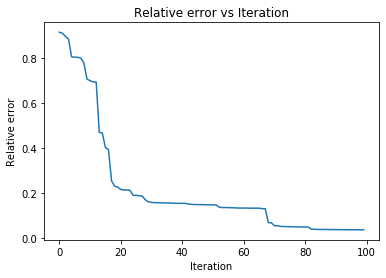

In [58]:
#np.random.seed(1)
A, S, error = nmfals(X, 3, 100, 10)
print(np.round(np.matmul(A,S), 2))
print(error[99])
plt.plot(error)
plt.title("Relative error vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.show()

Unfortunately, the ALS algorithm does not always closely resemble the original data matrix in practice, as the random initializations of $A$ and $S$ can cause the resulting approximation to vary wildly even with multiple iterations. This makes sense, as there are many different factorizations that a matrix can have. While the factorized $A$ and $S$ don't form a matrix that matches $X$ closely, it did preserve the row and column of zeros that were present in $X$. 

One thing to note is we use the relative error to judge the quality of our approximation, which is the Frobenius norm of the difference between our original data matrix $X$ and the approximation $AS$ divided by the Frobenius norm of $X$. We do this rather than just use the raw error since factorizations can be scaled by multiplying $A$ by a number $r$ and $S$ by $\frac{1}{r}$. This scaling also scales the error, hence the need for a relative metric. 

Let's also write a version with a projection function for nonnegative constraints later.

In [5]:
def nmfalsproj(data, f, k, niter, reinit = 1):
    # set to negative one so we can guarantee an update for the first init
    finalerror = -1
    
    # need to compare final error to overall best and store the overall best
    seqerror = np.empty(niter)
    lowesterror = np.empty(1)
    
    # store overall best factor matrices
    lbest = np.random.rand(data.shape[0], k)
    rbest = np.random.rand(k, data.shape[1])
    
    for j in np.arange(reinit):
        # randomly initialize the factor matrices
        lfactor = np.random.rand(data.shape[0], k)
        rfactor = np.random.rand(k, data.shape[1])

        for i in np.arange(niter):            
            # sample random row or column
            row = np.random.randint(data.shape[0])
            col = np.random.randint(data.shape[1])
            
            # perform linear reg update 
            rfactor[:, col] = np.matmul(np.linalg.pinv(lfactor), data[:, col])
            lfactor[row, :] = np.matmul(data[row, :], np.matmul(rfactor.T, np.linalg.inv(np.matmul(rfactor, rfactor.T))))
            # projection for nonnegativity
            lfactor[row, :] = f(lfactor[row, :], i+1)
            rfactor[:, col] = f(rfactor[:, col], i+1)
            # calculate error after update
            seqerror[i] = np.linalg.norm(data - np.matmul(lfactor, rfactor)) / np.linalg.norm(data)
        # update after first init
        if (finalerror == -1):
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
        # if not first, only update if final error is lower than overall best
        elif (finalerror > seqerror[niter - 1]):
            finalerror = seqerror[niter - 1]
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
    return(lbest, rbest, lowesterror)

## Randomized Kaczmarz Method

We saw previously that the algorithm to factorize $X$ has two main parts, one to pick our matrix column and row indices and one to take an iterative step towards the local optimum. The iterative step gives us the freedom to choose our favorite method to solve for $A$ and $S$, and rather than doing a traditional least squares method we can try applying the Randomized Kaczmarz(RK) method instead. This iterative step takes our randomly chosen row/column of either $A$ or $S$ and projects it towards the local optimum. It is equivalent to stochastic gradient descent with a specific step size when the matrix is positive definite.

Our current system $AS = X$ is reduced to $As_{:,i} = x_{:,i}$ when a column is sampled. Our RK iterative step then samples a row of $A$ and corresponding entry $k$ of $s_{:,i}$ and would then be the following:

$$s_{:,i}^{(j+1)} = s_{:,i}^{(j)} + \frac{x_{k,i} - a_{k,:}s_{:,i}}{\lvert\lvert{a_{k,:}}\rvert\rvert ^2}a_{k,:}^T$$

Note that $j$ represents the current iteration of our RK method. This value can be explicitly chosen, making it an additional parameter in this algorithm. If we sampled a row of $S$ rather than a column of $A$, each step would instead be the following:

$$a_{i,:}^{(j+1)} = a_{i,:}^{(j)} + \frac{x_{i,k} - a_{i,:}s_{:,k}}{\lvert\lvert{s_{:,k}}\rvert\rvert ^2}s_{:,k}^T$$

To summarize, we start by randomly sampling a row/column to reduce to a linear system(as usual). We then proceed to take RK steps, with each step sampling a random row and entry and updating. The number of steps before resampling our linear system can be provided as a parameter. To summarize, we start by randomly sampling a row/column to reduce to a linear system(as usual). We then proceed to take RK steps, with each step sampling a random row and entry and updating. The number of steps before resampling our linear system can be provided as a parameter. 

It's important to note that dividing by a vector norm means that we have to avoid sampling the rows/columns of our factor matrices that are all zero. This can be done by doing a weighted sample based on the norms of the rows/columns where a row with twice the magnitude of another will be sampled twice as often and a row with zero norm will never be sampled. It's also a good idea to do the same with the kaczmarz indices for reasons explained more clearly later. 

In [3]:
# mode 1 samples rows
def weightsample(data, mode):
    prob = np.linalg.norm(data, axis=mode)
    return(prob / sum(prob))

In [10]:
print(factors)
print(weightsample(factors, 1))

[[0.  0.  0. ]
 [0.  0.  5. ]
 [9.  0.  5. ]
 [5.  0.  6. ]
 [3.  0.  6. ]
 [2.  3.  7. ]
 [1.  2.  4. ]
 [0.  1.  2. ]
 [0.  1.  1. ]
 [0.  0.  0.5]
 [0.  0.  0. ]
 [0.  0.  0. ]]
[0.         0.10770999 0.22178845 0.16824839 0.14450812 0.16962186
 0.09871784 0.04816937 0.03046499 0.010771   0.         0.        ]


In [79]:
np.random.seed(1)
k = 3
niter = 100
factors = factors 
weights = weights 
X = np.round(np.matmul(factors, weights), 2)

A = factors + 0.01*np.random.rand(12, 3)
S = weights + 0.01*np.random.rand(3, 10)

kacziters = 1000
for j in np.arange(niter):
    row = np.random.choice(X.shape[0], p = weightsample(np.matmul(A, S), 1))
    col = np.random.choice(X.shape[1], p = weightsample(np.matmul(A, S), 0))
    for i in np.arange(kacziters):
        kaczrow = np.random.randint(len(X[:, col]))
        kaczcol = np.random.randint(len(X[row, :]))
        S[:, col] = S[:, col] + (X[kaczrow, col] - np.matmul(A[kaczrow, :], S[:, col])) / (np.linalg.norm(A[kaczrow, :])**2) * A[kaczrow, :]
        A[row, :] = A[row, :] + (X[row, kaczcol] - np.matmul(A[row, :], S[:, kaczcol])) / (np.linalg.norm(S[:, kaczcol])**2) * S[:, kaczcol] 

approx = np.matmul(A, S)
print(X)
print(np.round(approx, 2))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[-0.   -0.    0.   -0.    0.   -0.   -0.   -0.   -0.01  0.  ]
 [ 0.55  0.91 -0.01  0.67 -0.58  0.24  0.1   0.14  4.76 -0.01]
 [ 9.   17.46  0.17 17.25  7.43  4.89  2.18 11.47 89.8   0.  ]
 [ 2.98  5.04  0.04  4.03 -0.13  1.38  0.77  2.1  29.12  0.  ]
 [ 4.06  9.   -0.02  9.99  2.49  2.51  0.54  5.75 36.24 -0.08]
 [ 1.62  5.36 -0.04  7.75  3.97  1.54 -0.14  5. 

The RK method's relative error is nowhere near comparable to that of ALS even when the number of RK iterations is in the thousands due to the presence of more negative entries. 

The finalized function is largely similar to the ALS one, except the ALS iterative step is substituted for the RK iteration loop. 

In [7]:
def rk(data, k, niter, kacziter, reinit = 1):
    # set to negative one so we can guarantee an update for the first init
    finalerror = -1
    
    # need to compare final error to overall best and store the overall best
    seqerror = np.empty(niter)
    lowesterror = np.empty(1)
    
    # store overall best factor matrices
    lbest = np.random.rand(data.shape[0], k)
    rbest = np.random.rand(k, data.shape[1])
    
    for l in np.arange(reinit):
        # randomly initialize the factor matrices
        lfactor = np.random.rand(data.shape[0], k)
        rfactor = np.random.rand(k, data.shape[1])
        
        # outer loop for number of iterations 
        for i in np.arange(niter):
            approx = np.matmul(lfactor, rfactor)
            
            # weighted sampling of row and column from data approx matrix
            row = np.random.choice(data.shape[0], size = 1, p = weightsample(approx, 1))
            col = np.random.choice(data.shape[1], size = 1, p = weightsample(approx, 0))
            
            # inner loop for number of RK iterations
            for j in np.arange(kacziter):
                # sample index for entry of data matrix
                kaczrow = np.random.choice(lfactor.shape[0], size = 1, p = weightsample(lfactor, 1))
                kaczcol = np.random.choice(rfactor.shape[1], size = 1, p = weightsample(rfactor, 0))

                # compute RK step
                lfactor[row, :] = lfactor[row, :] + (data[row, kaczcol] - np.matmul(lfactor[row, :], rfactor[:, kaczcol])) / (np.linalg.norm(rfactor[:, kaczcol])**2) * rfactor[:, kaczcol].T 
                rfactor[:, col] = rfactor[:, col] + (data[kaczrow, col] - np.matmul(lfactor[kaczrow, :], rfactor[:, col])) / (np.linalg.norm(lfactor[kaczrow, :])**2) * lfactor[kaczrow, :].T
     
            # calculate error after update
            seqerror[i] = np.linalg.norm(data - np.matmul(lfactor, rfactor)) / np.linalg.norm(data)
        # update after first init
        if (finalerror == -1):
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
        # if not first, only update if final error is lower than overall best
        elif (finalerror > seqerror[niter - 1]):
            finalerror = seqerror[niter - 1]
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
    return(lbest, rbest, lowesterror)

0.1624292170543148


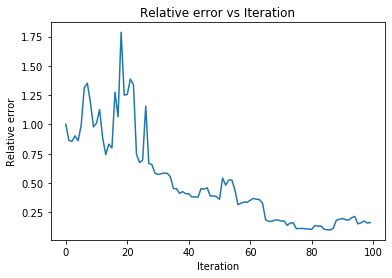

In [65]:
A, S, error = nmfrk(X, k = 3, niter = 100, kacziter = 1000, reinit = 1)

approx = np.matmul(A, S)
#print(np.round(approx, 2))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))
plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

We can start to notice that RK is more inclined to have negative entries, which further increases the error as other entries grow larger to compensate. We can address this problem by introducing a nonnegativity constraint.

## Option 1: Projection 

The simplest and easiest method is to project each iteration into the feasible space, which in this case is the nonnegative numbers. We merely need to check whether an element of our iteration result is negative, and set it directly to 0 if so. That is,

$$ x_{k,i} = \max{ \{ x_{k,i}, 0 \}} $$

It is important to perform a weighted sampling of kaczmarz columns/rows because a hard projection to 0 can easily lead to a row or column of zeros if all the entries are negative. A weighted sample will hopefully keep our algorithm from dividing by 0 at any point.

In [8]:
def proj(vec, i):
    return(np.where(vec < 0, 0, vec))

In [8]:
def nmfrkproj(data, f, k, niter, kacziter, reinit = 1):
    # set to negative one so we can guarantee an update for the first init
    finalerror = -1
    
    # need to compare final error to overall best and store the overall best
    seqerror = np.empty(niter)
    lowesterror = np.empty(1)
    
    # store overall best factor matrices
    lbest = np.random.rand(data.shape[0], k)
    rbest = np.random.rand(k, data.shape[1])
    
    for l in np.arange(reinit):
        # randomly initialize the factor matrices
        lfactor = np.random.rand(data.shape[0], k)
        rfactor = np.random.rand(k, data.shape[1])
        
        # outer loop for number of iterations 
        for i in np.arange(niter):
            approx = np.matmul(lfactor, rfactor)
            
            # weighted sampling of row and column from data approx matrix
            row = np.random.choice(data.shape[0], size = 1, p = weightsample(approx, 1))
            col = np.random.choice(data.shape[1], size = 1, p = weightsample(approx, 0))
            
            # inner loop for number of RK iterations
            for j in np.arange(kacziter):
                # sample index for entry of data matrix
                kaczrow = np.random.choice(lfactor.shape[0], size = 1, p = weightsample(lfactor, 1))
                kaczcol = np.random.choice(rfactor.shape[1], size = 1, p = weightsample(rfactor, 0))

                # compute RK step
                lfactor[row, :] = lfactor[row, :] + (data[row, kaczcol] - np.matmul(lfactor[row, :], rfactor[:, kaczcol])) / (np.linalg.norm(rfactor[:, kaczcol])**2) * rfactor[:, kaczcol].T 
                rfactor[:, col] = rfactor[:, col] + (data[kaczrow, col] - np.matmul(lfactor[kaczrow, :], rfactor[:, col])) / (np.linalg.norm(lfactor[kaczrow, :])**2) * lfactor[kaczrow, :].T
     
                # project to feasible space
                lfactor[row, :] = f(lfactor[row, :], j+1)
                rfactor[:, col] = f(rfactor[:, col], j+1)
                
            # calculate error after update
            seqerror[i] = np.linalg.norm(data - np.matmul(lfactor, rfactor)) / np.linalg.norm(data)
        # update after first init
        if (finalerror == -1):
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
        # if not first, only update if final error is lower than overall best
        elif (finalerror > seqerror[niter - 1]):
            finalerror = seqerror[niter - 1]
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
    return(lbest, rbest, lowesterror)

### Hard Projection with 100 iterations, 1000 RK iterations

In [17]:
np.random.seed(1)
A, S, error = nmfrkproj(X, proj, k = 3, niter = 100, kacziter = 1000, reinit = 1)

approx = np.matmul(A, S)
#print(X)
#print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))
plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

C:\Users\Edwin\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Edwin\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in multiply
C:\Users\Edwin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


ValueError: probabilities contain NaN

A hard projection is not an ideal solution, as evident by the NaN error. For example, if a row or column is updated to have all negative entries, all entries will be projected to zero. This will slow down convergence greatly, or even throw a divide by zero error. Thus we move on to another option.

## Option 2: "Soft" Projection

Because a direct projection failed to work, we can try a "soft" projection where negative entries are sent to a negative value very close to zero. This way a full row or column of negative entries won't cause any computational errors. This can either be done by assigning to a constant or a value dependent on iteration count. That is

$$ x_{k,i} = \max{ \{ x_{k,i}, -c \}} \text{,  } c << 10^{-3} \textbf{  or} $$
$$ x_{k,i} = \max{ \{ x_{k,i}, -\frac{1}{\sqrt{j}} \}},  j^{th} \text{ iteration}$$

With this nonnegativity constraint we avoid the problem of setting a whole row or column to zero, but it is still important to perform a weighted sample of kaczmarz rows/columns. With a uniform sample, rows will small norms can be repeatedly selected to divide a column with large entries, or vice versa. This will blow up the already large entries, and the opposite effect will occur when updating rows/columns with small entries by a row/column with a large norm. This repeated increase of already large entries and decrease of already small entries will result in a rather poor approximation. Thus the need for a weighted sample's regularization effect. 

In [7]:
def softprojc(vec, i, c = -1e-5):
    return(np.where(vec < c, c, vec))
def softproji(vec, i):
    return(np.where(vec < 0, (-1 / np.sqrt(i)), vec))

## Option 3: Line search 

One more option to ensure nonnegativity is to perform a line search along the orthogonal projection during a typical RK step. This allows us to "backtrack" until we're left with all nonnegative entries, which is more natural than a projection of all negative entries. We can achieve this by finding the most negative entry and adjusting the step size taken such that it equals zero. This ensures the rest of the entries will be nonnegative. 

Just as before, suppose we are solving the linear system 

$$ x_{:,i} \approx As_{:,i}$$

Using a randomized kaczmarz update rule, we update $s_{:,i}$ with 

$$s_{:,i}^{(j+1)} = s_{:,i}^{(j)} + \gamma a_{k,:}$$

where $\gamma$ is the appropriate RK step size. To ensure nonnegativity we want to maximize $\gamma$ while keeping all our updated entries larger than zero, 

$$\operatorname{max}{\{\gamma\}} \\ \text{s.t.} \: s_{:,i}^{(j)} + \gamma a_{k,:} > 0 \; \forall k$$

Setting equal to zero and solving gives us a new step size $\operatorname{max}{\{\gamma\}} = \underset{l \in \{1,...,l\}}{\operatorname{argmin}}-\frac{s_{i,l}}{a_{k,l}}$ or $\operatorname{min}{\{\gamma\}} = \underset{l \in \{1,...,l\}}{\operatorname{argmin}}\frac{s_{i,l}}{a_{k,l}}$. We also multiply by the sign of the normal RK step size to preserve the direction of the step when finding the minimum. Thus our nonnegative RK step size is 

$$ \gamma = \min \{ \frac{x_{k,i} - a_{k,:}^Ts_{:,i}}{\lvert\lvert{a_{k,:}}\rvert\rvert ^2}, \underset{l \in \{1,...,n\}}{\operatorname{argmin}} \{ \operatorname{sgn}{(\frac{x_{k,i} - a_{k,:}^Ts_{:,i}}{\lvert\lvert{a_{k,:}}\rvert\rvert ^2})}\frac{s_{l,i}}{a_{k,l}} \} \}$$

In [21]:
def linesearch(x, a, s):
    sign = np.sign(x - np.matmul(a, s))
    lsmin = np.min(sign*(s / a))
    rk = (x - np.matmul(a, s)) / (np.linalg.norm(s)**2)
    return(min(lsmin, rk)) 

In [22]:
def nmfrkls(data, f, k, niter, kacziter, reinit = 1):
    # set to negative one so we can guarantee an update for the first init
    finalerror = -1
    
    # need to compare final error to overall best and store the overall best
    seqerror = np.empty(niter)
    lowesterror = np.empty(1)
    
    # store overall best factor matrices
    lbest = np.random.rand(data.shape[0], k)
    rbest = np.random.rand(k, data.shape[1])
    
    for l in np.arange(reinit):
        # randomly initialize the factor matrices
        lfactor = np.random.rand(data.shape[0], k)
        rfactor = np.random.rand(k, data.shape[1])
        
        # outer loop for number of iterations 
        for i in np.arange(niter):
            
            approx = np.matmul(lfactor, rfactor)
            
            # weighted sampling of row and column from data matrix
            row = np.random.choice(data.shape[0], size = 1, p = weightsample(approx, 1))
            col = np.random.choice(data.shape[1], size = 1, p = weightsample(approx, 0))
            
            # inner loop for number of RK iterations
            for j in np.arange(kacziter):
                # sample index for entry of data matrix
                kaczrow = np.random.choice(lfactor.shape[0], size = 1, p = weightsample(lfactor, 1))
                kaczcol = np.random.choice(rfactor.shape[1], size = 1, p = weightsample(rfactor, 0))

                # compute RK step
                step = f(data[row, kaczcol], lfactor[row, :], rfactor[:, col])
                lfactor[row, :] = lfactor[row, :] + step * rfactor[:, kaczcol].T
                rfactor[:, col] = rfactor[:, col] + step * lfactor[kaczrow, :].T
                #print(j, kaczrow, kaczcol)
                #print(lfactor)
                #print(rfactor)
            # calculate error after update
            seqerror[i] = np.linalg.norm(data - np.matmul(lfactor, rfactor)) / np.linalg.norm(data)
        # update after first init
        if (finalerror == -1):
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
        # if not first, only update if final error is lower than overall best
        elif (finalerror > seqerror[niter - 1]):
            finalerror = seqerror[niter - 1]
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
    return(lbest, rbest, lowesterror)

In [23]:
A, S, error = nmfrkls(X, linesearch, k = 3, niter = 100, kacziter = 100, reinit = 1)

approx = np.matmul(A, S)
#print(X)
#print(np.round(approx, 1))
#print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

C:\Users\Edwin\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2506: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
C:\Users\Edwin\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


ValueError: probabilities contain NaN

Unfortunately, our line search causes an error. Upon closer inspection of the updates(which are not shown due to the length), we will see a row/column of entries approaching infinity while all other entries are values close to zero. This is rather unexpected, but one possible explanation is that updates inevitably set at least one entry to zero each time. The line search backtracks until only one entry is 0, but all other entries in that row or column are also backtracked in the process. This leads to one entry increasing more than it decreases after each RK iteration, approaching infinity and throwing an error.

## Block Randomized Kaczmarz

To generalize the randomized kaczmarz method, one can increase its dimensionality by sampling and updating multiple rows/columns $\tau$ simultaneously. This gives rise to the appropriately named block randomized kaczmarz method. The number of rows/columns $k$ that are sampled can be treated as a parameter, and our new iterative update would be the following:

$$s_{:,i}^{(j+1)} = s_{:,i}^{(j)} + (A_{\tau,:})^{\dagger}(x_{\tau,i} - A_{\tau,:}s_{:,i}^{(j)})$$
$$a_{i,:}^{(j+1)} = a_{i,:}^{(j)} + (x_{i,\tau} - a_{i,:}S_{:,\tau})(S_{:,\tau})^{\dagger}$$

In [30]:
def brk(data, k, s, niter, kacziter, reinit = 1):
    # set to negative one so we can guarantee an update for the first init
    finalerror = -1
    
    # need to compare final error to overall best and store the overall best
    seqerror = np.empty(niter)
    lowesterror = np.empty(1)
    
    # store overall best factor matrices
    lbest = np.random.rand(data.shape[0], k)
    rbest = np.random.rand(k, data.shape[1])
    
    for l in np.arange(reinit):
        # randomly initialize the factor matrices
        lfactor = np.random.rand(data.shape[0], k)
        rfactor = np.random.rand(k, data.shape[1])
        
        # outer loop for number of iterations 
        for i in np.arange(niter):
            approx = np.matmul(lfactor, rfactor)
            
            # weighted sampling of row and column from data matrix
            row = np.random.choice(data.shape[0], size = 1, p = weightsample(approx, 1))
            col = np.random.choice(data.shape[1], size = 1, p = weightsample(approx, 0))
            #row = np.random.choice(data.shape[0], p = weightsample(approx, 1))
            #col = np.random.choice(data.shape[1], p = weightsample(approx, 0))
            
            # inner loop for number of RK iterations
            for j in np.arange(kacziter):
                # sample indices until at least one nonzero row or col
                
                resample = True
                while(resample):
                    rowsum = 0
                    colsum = 0
                    kaczrow = np.random.choice(lfactor.shape[0], size = s, replace = False)
                    kaczcol = np.random.choice(rfactor.shape[1], size = s, replace = False)

                    for samplerow in kaczrow:
                        rowsum = rowsum + sum(lfactor[samplerow, :])
                    for samplecol in kaczcol:
                        colsum = colsum + sum(rfactor[:, samplerow])
                    if (rowsum > 0 and colsum > 0):
                        resample = False

                # compute BRK step
                #kaczrow = np.random.choice(lfactor.shape[0], size = s, replace = False)
                #kaczcol = np.random.choice(rfactor.shape[1], size = s, replace = False)

                lfactor[row, :] = lfactor[row, :] + np.matmul((data[row, kaczcol] - np.matmul(lfactor[row, :], rfactor[:, kaczcol])), np.linalg.pinv(rfactor[:, kaczcol]))
                rfactor[:, col] = rfactor[:, col] + np.matmul(np.linalg.pinv(lfactor[kaczrow, :]), (data[kaczrow, col, None] - np.matmul(lfactor[kaczrow, :], rfactor[:, col])))

            # calculate error after update
            seqerror[i] = np.linalg.norm(data - np.matmul(lfactor, rfactor)) / np.linalg.norm(data)
        # update after first init
        if (finalerror == -1):
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
        # if not first, only update if final error is lower than overall best
        elif (finalerror > seqerror[niter - 1]):
            finalerror = seqerror[niter - 1]
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
    return(lbest, rbest, lowesterror)

A notable change in this algorithm compared to previous ones is the exclusion of weighted sampling for the kaczmarz row/columns. The issue with weighted sampling is the fact that there may be more zero rows/columns than our block size, thus there will be more zero probability vectors than our sample size. 

We can opt to relax this step and instead sample blocks until at least one of the rows/columns are nonzero. 

## Coordinate Methods / Gauss-Seidel

Another optimization method comparable to randomized kaczmarz is Gauss-Seidel. To summarize, randomized kaczmarz samples a constraint and optimizes with respect to it, acting equivalent to a gradient descent step with a specific step size. Gauss-Seidel performs in a similar way, except it samples a column and optimizes in that dimension using a Gauss-Seidel update step:

$$ s_{:, i}^{(j+1)} = s_{:, i}^{(j)} + I_{:, \tau}A_{:, \tau}^{\dagger}(x_{:, i} - As_{:, i}^{(j)})$$
$$ a_{i, ;}^{(j+1)} = a_{i, :}^{(j)} + (x_{i,:} - a_{i,:}^{(j)}S)S_{\tau, :}^{\dagger}I_{\tau, :}$$

where $I$ is a $kxk$ identity matrix.

From an algorithm standpoint, implementations of RK and G-S methods for factorization seem quite similar, with the columns sampled instead of rows and vice versa. However, with rows and columns representing constraints and dimensions, respectively, there is an important distinction to be made here that is worth investigating. Furthermore, when solving overdetermined systems(where our factor matrices have $k << n$), Gauss-Seidel might be less efficient at solving very long $n\times 1$ vectors compared to RK, which solves shorter $k \times 1$ ones.

In [29]:
def bgs(data, k, s, niter, gsiter, reinit = 1):
    # set to negative one so we can guarantee an update for the first init
    finalerror = -1
    
    # need to compare final error to overall best and store the overall best
    seqerror = np.empty(niter)
    lowesterror = np.empty(1)
    
    # store overall best factor matrices
    lbest = np.random.rand(data.shape[0], k)
    rbest = np.random.rand(k, data.shape[1])
    
    for l in np.arange(reinit):
        # randomly initialize the factor matrices
        lfactor = np.random.rand(data.shape[0], k)
        rfactor = np.random.rand(k, data.shape[1])
        
        # outer loop for number of iterations 
        for i in np.arange(niter):
            approx = np.matmul(lfactor, rfactor)
            
            # weighted sampling of row and column from data matrix

            row = np.random.choice(data.shape[0], size = 1, p = weightsample(approx, 1))
            col = np.random.choice(data.shape[1], size = 1, p = weightsample(approx, 0))
            
            
            # inner loop for number of RK iterations
            for j in np.arange(gsiter):
                # sample indices for entry of data matrix, dont want norms in rk step to be 0
                if s == 1:
                    gsrow = np.random.choice(rfactor.shape[0], size = s, p = weightsample(rfactor, 1))
                    gscol = np.random.choice(lfactor.shape[1], size = s, p = weightsample(lfactor, 0))

                else:
                    resample = True
                    while(resample):
                        rowsum = 0
                        colsum = 0
                        gscol = np.random.choice(lfactor.shape[1], size = s, replace = False)
                        gsrow = np.random.choice(rfactor.shape[0], size = s, replace = False)

                        for samplerow in gsrow:
                            rowsum = rowsum + sum(lfactor[samplerow, :])
                        for samplecol in gscol:
                            colsum = colsum + sum(rfactor[:, samplerow])
                        if (rowsum > 0 and colsum > 0):
                            resample = False

                # compute BGS step
                lfactor[row, :] = lfactor[row, :] + np.matmul((data[row, :] - np.matmul(lfactor[row, :], rfactor)), np.matmul(np.linalg.pinv(rfactor[gsrow, :]), np.eye(k)[:, gscol].T))
                rfactor[:, col] = rfactor[:, col] + np.matmul(np.matmul(np.eye(k)[:, gscol], np.linalg.pinv(lfactor[:, gscol])), (data[:, col] - np.matmul(lfactor, rfactor[:, col])))

            # calculate error after update
            seqerror[i] = np.linalg.norm(data - np.matmul(lfactor, rfactor)) / np.linalg.norm(data)
        # update after first init
        if (finalerror == -1):
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
        # if not first, only update if final error is lower than overall best
        elif (finalerror > seqerror[niter - 1]):
            finalerror = seqerror[niter - 1]
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
    return(lbest, rbest, lowesterror)

An interesting result when testing this method for $k = 1$ is that it tends to send many, if not all rows/columns to zero. However, this does not occur when performing block updates, which actually have a nonincreasing error. 

# Miscellaneous Tests

### Soft Projection with 100 iterations, 1000 rk iterations

[[-0.03162278  0.01268355 -0.03162278]
 [ 0.36746308  0.09602564 -0.03162278]
 [ 0.41284336  1.71186768  1.99783939]
 [ 1.1286422   0.51598125  1.12841828]
 [ 0.76317757  0.43037698  0.6437667 ]
 [ 1.10736217  0.56971154  0.46393001]
 [ 0.23403685  0.66763343  0.32896012]
 [ 0.42289625  0.0220869  -0.03162278]
 [ 0.2322075   0.04905246 -0.03162278]
 [ 0.00181219  0.13628051 -0.03162278]
 [-0.03162278  0.01881253  0.06297317]
 [-0.03162278  0.0542596  -0.03162278]]
[[ 0.06471652  6.44770083  0.01705085 -0.03162278  7.37631276  0.67074687
   0.43501718  2.31269764  3.47623046 -0.03162278]
 [ 0.28987846  5.94598194  0.00388598  0.0191429   6.28298708  0.47527724
   1.90954083  2.68703935  4.94972884 -0.03162278]
 [ 4.02394761  0.58031454 -0.03162278 -0.03162278  0.90134005  3.77699246
   3.52150589  1.95755562  2.04800273  0.08643309]]
0.1773346064963157


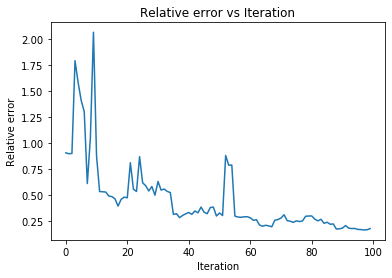

In [13]:
A, S, error = nmfrkproj(X, softproji, k = 3, niter = 100, kacziter = 1000, reinit = 1)

approx = np.matmul(A, S)
#print(X)
print(A)
print(S)
#print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

### ALS comparison with 100 iterations

[[ 0.          0.          0.        ]
 [-0.1132277   0.43521396  0.00515596]
 [ 3.70275379 -0.11111111  0.64218808]
 [ 1.78574376  0.09271424  0.35356065]
 [ 0.75376234  0.25388237  0.21561133]
 [ 7.98760877  0.45890345  0.22222806]
 [ 5.31964715  0.3088517   0.12395827]
 [ 2.38235262  0.18093809  0.02658939]
 [ 2.68505813  0.08969228  0.02084914]
 [-0.10101525  0.0384114   0.00027627]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[-0.1         0.02511578  0.          0.41039194  0.05432688 -0.10721125
  -0.10153462  0.26705644 -0.10259784  0.        ]
 [-0.1        13.05190897  0.          0.38391803 12.69224246 -0.10721125
  -0.10153462  0.10135819 12.72749595  0.        ]
 [14.79141458 25.17089757  0.         -0.10540926 24.76172787 14.60975293
  14.78973581 12.58469329 27.35790683  0.        ]]
0.09369115364972734


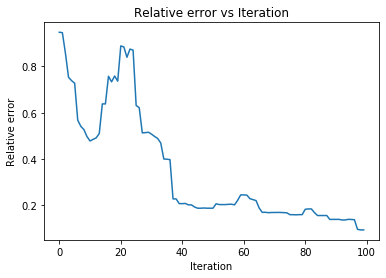

In [20]:
A, S, error = nmfalsproj(X, softproji, k = 3, niter = 100, reinit = 1)

approx = np.matmul(A, S)
#print(X)
print(A)
print(S)
#print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

### Soft Projection with 1000 iterations, 1000 rk iterations

[[ 0.65483634  0.40307984  0.89313743]
 [ 0.86033839  1.21675673 -0.00001   ]
 [ 0.47774455  3.32642848  0.09087835]
 [ 0.55416719  2.97412818 -0.00001   ]
 [ 0.15625814  1.03209589  0.00001334]
 [ 2.60439557  0.73920364  0.00283923]
 [ 0.40311301  1.18801066  0.0056332 ]
 [ 1.00972745  0.47417438  0.00170767]
 [ 0.77596023  0.0167219  -0.00001   ]
 [ 0.09446987  0.0000005   0.00030077]
 [ 0.8698245   0.33382573  0.95666396]
 [ 0.03219383  0.03052919  0.76137316]]
[[-0.00001    -0.00001     0.87561308  0.51000607  2.16647373 -0.00001
   0.05989646  0.58656646 -0.00001     0.00202972]
 [ 1.58550617  4.20867768  0.2453818  -0.00001     4.88397264  0.28875582
   0.89203241  0.85954754  4.20871988  0.85779693]
 [-0.00001     0.02298424  0.36368593 -0.00001     0.02505305  0.00000924
   0.00444174  0.0891974  -0.00001     0.67602328]]
0.480244965669721


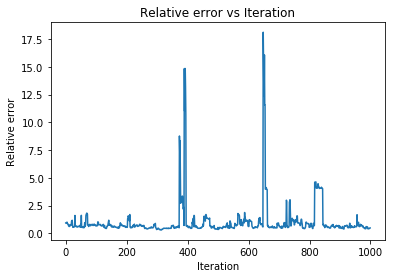

In [24]:
#np.random.seed(1)
A, S, error = nmfrkproj(X, softprojc, k = 3, niter = 1000, kacziter = 1000, reinit = 1)

approx = np.matmul(A, S)
#print(X)
print(A)
print(S)
#print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

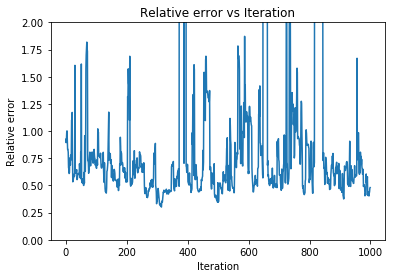

In [26]:
plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.ylim(0,2)
plt.show()

### Soft Projection with 1000 iterations, 1000 rk iterations

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 0.6  1.5  0.8  0.5  1.2  0.5  0.1  0.5  1.2  0.7]
 [ 0.6  6.3  0.6  0.4  4.6  0.6  0.   1.1  5.   0.8]
 [ 8.9 22.1  2.   1.  18.2  8.4  2.7  8.1 17.3  2.8]
 [14.5 18.7  1.8  0.5 17.5 13.5  5.  11.1 14.6  2.2]
 [ 3.  11.2  1.   0.6  8.8  2.9  0.7  3.1  8.8  1.4]
 [ 3.9 15.4  1.4  0.8 12.   3.8  1.   4.2 12.1  2. ]
 [ 2.   9.1  0.8  0.5  7.   1.9  0.4  2.3  7.

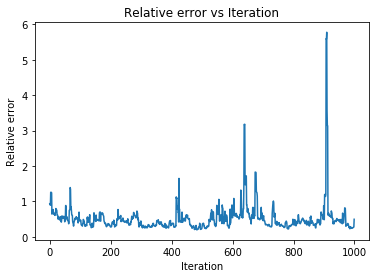

In [73]:
#np.random.seed(1)
A, S, error = nmfrkproj(X, softproji, k = 3, niter = 1000, kacziter = 1000, reinit = 1)

approx = np.matmul(A, S)
print(X)
print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

### ALS comparison with 1000 iterations

[[ 0.          0.          0.        ]
 [-0.03173404 -0.03173404  3.79294854]
 [ 0.88036464  0.00652986  0.28890088]
 [ 0.46401095 -0.03327792  2.6062461 ]
 [ 0.25814601 -0.03168621  3.38684228]
 [-0.03167032  1.09958551  5.31759665]
 [-0.03200922  0.73673221  3.16946053]
 [-0.03165445  0.36559154  1.77846827]
 [-0.0316386   0.37388955  1.02002487]
 [-0.03171807 -0.03171807  0.37928305]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[10.16681085 15.37881358  0.         -0.03204207 15.37864861 10.17683724
  10.17699605 10.14283082 15.39877221  0.        ]
 [ 1.29940863  3.66647305  0.          2.59395611  3.66551124  1.30025376
   1.30020742  3.88966654  1.07050026  0.        ]
 [ 0.12378911  1.52150534  0.          0.0274107   1.52152381  0.12277342
   0.12261635  0.15150923  1.49424863  0.        ]]
0.043463672750609694


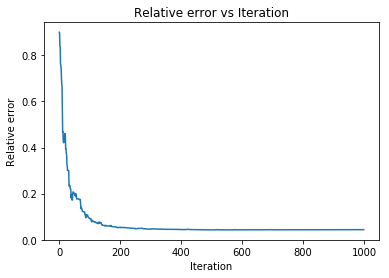

In [32]:
A, S, error = nmfalsproj(X, softproji, k = 3, niter = 1000, reinit = 5)

approx = np.matmul(A, S)
#print(X)
print(A)
print(S)
#print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

### Soft Projection with 10000 iterations, 1000 rk iterations

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 0.3  1.   0.3  0.1  1.   0.1  0.4  0.8  1.1  0.8]
 [ 0.2  5.   1.7  1.   5.2  0.   0.2  2.6  3.8  1.8]
 [ 4.3 13.3  0.6 -0.3 11.4  4.4  9.   7.4  9.1  2.8]
 [ 3.2 12.5  0.5  0.1 11.   3.8  7.5  6.2  7.6  1. ]
 [ 3.  13.3  1.6  0.6 12.1  3.1  6.4  7.   9.   2.7]
 [ 2.  12.   1.6  0.9 11.1  2.4  4.9  5.7  7.5  1.5]
 [ 0.6  6.9  1.6  1.   6.8  0.7  1.4  3.2  4.

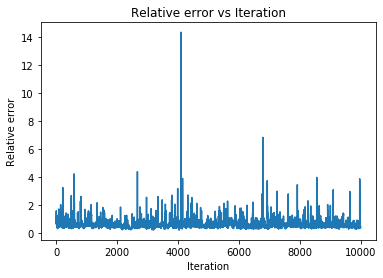

In [74]:
A, S, error = nmfrkproj(X, softproji, k = 3, niter = 10000, kacziter = 1000, reinit = 1)

approx = np.matmul(A, S)
print(X)
print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

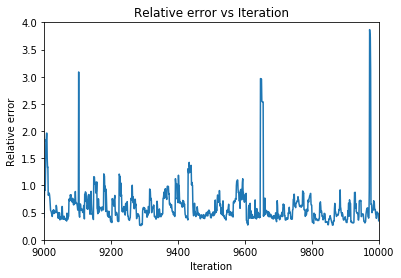

In [76]:
plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.ylim(0,4)
plt.xlim(9000, 10000)
plt.show()

### Soft Projection with 100 iterations, 100 rk iterations

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 0.5  2.   0.1  0.   1.4  1.3  0.9  0.5  0.7  0.6]
 [ 0.5  2.3  0.1  0.1  1.5  1.   0.6  0.5  0.6  0.3]
 [ 9.  36.3  2.8  0.7 25.4 19.8 13.7  9.  14.7  8.7]
 [ 3.6 16.3  1.4  0.2 11.   6.9  4.6  4.7  8.8  3.1]
 [ 2.   9.   0.3  0.5  5.9  4.6  3.   1.4  0.3  1.2]
 [ 2.6 12.   0.9  0.3  8.1  5.3  3.4  3.2  5.5  2.2]
 [ 2.3 10.4  0.8  0.2  7.   4.5  3.   2.8  5.

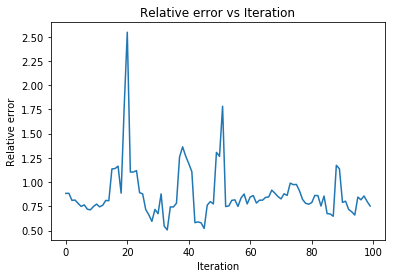

In [22]:
A, S, error = nmfrkproj(X, softproji, k = 3, niter = 100, kacziter = 100, reinit = 1)

approx = np.matmul(A, S)
print(X)
print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

### Soft Projection with 100 iterations, 1000 rk iterations

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 4.1  2.8  1.1  0.4  2.2  0.9  0.1  0.9  1.1  1.1]
 [11.7  7.4  1.   1.1  5.8  2.6  0.   1.9  2.6  1. ]
 [ 9.  20.8  2.3  1.1 13.   3.1  4.3  2.2 13.7  3.7]
 [ 3.4 11.   1.1  0.5  6.7  1.4  2.5  1.   7.6  1.9]
 [20.8 13.1  4.3  1.9 10.5  4.5  0.   4.   4.7  4.1]
 [31.7 22.5  3.   3.  17.2  7.1  0.6  5.2  9.   3.3]
 [-0.2  1.3  0.1  0.   0.7  0.1  0.4  0.   1.

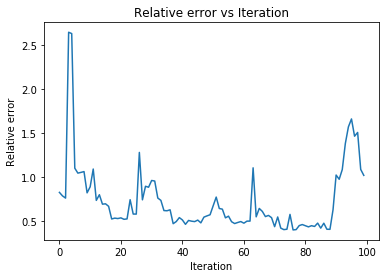

In [21]:
A, S, error = nmfrkproj(X, softproji, k = 3, niter = 100, kacziter = 1000, reinit = 1)

approx = np.matmul(A, S)
print(X)
print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

### Soft Projection with 100 iterations, 5000 rk iterations

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 0.1  1.2  0.3  0.3  1.3  0.1  0.1  1.1  0.5  0.3]
 [ 0.1  4.3  0.8  1.1  5.   0.1  0.1  3.9  1.5  1.1]
 [ 7.3  9.9  6.4  2.5 12.   9.3 10.5  9.  17.1  4.9]
 [ 2.   6.9  2.4  1.7  8.   2.6  3.   6.3  6.   2.2]
 [ 3.   2.7  2.4  0.7  3.4  3.8  4.3  2.5  6.6  1.8]
 [ 0.   4.9  0.8  1.2  5.6  0.   0.   4.5  1.4  1.1]
 [ 1.   7.6  2.   2.   8.9  1.3  1.4  7.   4.

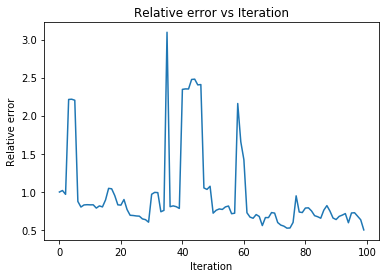

In [24]:
A, S, error = nmfrkproj(X, softproji, k = 3, niter = 100, kacziter = 5000, reinit = 1)

approx = np.matmul(A, S)
print(X)
print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

[[   0.           -0.            0.        ]
 [   2.68442793   -3.44408137   -4.97500137]
 [ -38.51027554   -5.50586388  132.52958738]
 [   6.0889117   -11.80590319  -10.04356085]
 [ -13.93119919    5.76211692   41.55074912]
 [  39.37570199  -11.24309104 -116.72094436]
 [  -2.73757266    0.23140423    9.97007287]
 [   7.34117249   -3.6730796   -20.75689893]
 [  10.07600084   -3.00195738  -29.95332777]
 [   0.25682041   -0.2558827    -0.57518997]
 [  -0.            0.            0.        ]
 [   0.           -0.            0.        ]]
[[ 6.60746244 18.3829728   0.          0.48646088 23.33104345  7.87886562
   2.51316853  9.76027443 25.48326589 -0.        ]
 [ 1.52668993  4.72428552 -0.          0.09500627  6.4028584   1.40737562
   0.81763502  0.0234703   7.19769466 -0.        ]
 [ 2.06482872  5.64360484  0.          0.14093627  7.15114411  2.53750375
   0.80537453  3.24752152  7.76251937 -0.        ]]
1.3145278766438702


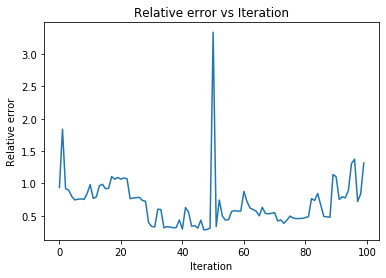

In [81]:
A, S, error = nmfbrk(X, k = 3, s = 2, niter = 100, kacziter = 1000, reinit = 1)

approx = np.matmul(A, S)
#print(X)
print(A)
print(S)
#print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

## Greatly Overdetermined Tests (Sparse)

### 50x50 matrix

In [30]:
factor1 = np.random.choice(4, size=(50,4), p=np.array([0.7, 0.1, 0.1, 0.1]))
weight1 = np.random.randint(0, 2, size=(4, 50))
X1 = np.matmul(factor1, weight1)
np.count_nonzero(X1 == 0)

1465

In [32]:
%%time
n = 15
data = X1
alserr1 = np.empty(n)

for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserr1[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserr1)

[0.45136494 0.43698176 0.4363842  0.37771993 0.37577656 0.41705682
 0.36641962 0.42158144 0.48966572 0.45562689 0.41804625 0.35354722
 0.36373014 0.45029846 0.43084978]
Wall time: 270 ms


In [33]:
%%time
n = 15
data = X1
rkerr1 = np.empty(n)

for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerr1[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerr1)

[0.75171378 0.82151471 1.09897192 1.19283408 0.76406524 0.95436508
 0.87100577 0.94824233 1.15145259 0.98472032 0.75657745 1.0455214
 0.80923433 0.96120702 1.18211534]
Wall time: 3min 28s


### 200x200 matrix

In [34]:
factor2 = np.random.choice(4, size=(200,4), p=np.array([0.7, 0.1, 0.1, 0.1]))
weight2 = np.random.randint(0, 2, size=(4, 200))
X2 = np.matmul(factor2, weight2)
np.count_nonzero(X2 == 0)

20632

In [35]:
%%time
n = 15
data = X2
alserr2 = np.empty(n)

for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserr2[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserr2)

[0.71365003 0.68446493 0.71108089 0.71616292 0.70208409 0.69262003
 0.72416488 0.68118219 0.67135471 0.68566099 0.68976153 0.7081446
 0.7015997  0.71751633 0.70222149]
Wall time: 495 ms


In [36]:
%%time
n = 15
data = X2
rkerr2 = np.empty(n)
for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerr2[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerr2)

[0.85457086 0.90503818 1.06615227 0.9360997  0.97662543 0.89612451
 0.91747927 0.87655955 0.87916547 0.89832067 0.89882213 0.81931112
 0.99436504 0.89551127 0.84589193]
Wall time: 5min 1s


### 1000x1000 matrix

In [37]:
factor3 = np.random.choice(4, size=(1000,4), p=np.array([0.7, 0.1, 0.1, 0.1]))
weight3 = np.random.randint(0, 2, size=(4, 1000))
X3 = np.matmul(factor3, weight3)
np.count_nonzero(X3 == 0)

526212

In [38]:
%%time
n = 15
data = X3
alserr3 = np.empty(n)

for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserr3[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserr3)

[0.80543846 0.80829628 0.80384723 0.80287643 0.81385427 0.82073791
 0.81082583 0.81162477 0.81429148 0.80788002 0.80742933 0.81211538
 0.80789517 0.81668427 0.80467864]
Wall time: 16.2 s


In [39]:
%%time
n = 15
data = X3
rkerr3 = np.empty(n)
for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerr3[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerr3)

[0.86934802 0.85004217 0.86081305 0.85442019 0.85028617 0.84638056
 0.85001861 0.89631342 0.85015334 0.83955846 0.87155388 0.86517336
 0.84118141 0.86012668 0.84539579]
Wall time: 12min 47s


### 10,000x10,000 matrix

In [40]:
factor4 = np.random.choice(4, size=(10000,4), p=np.array([0.7, 0.1, 0.1, 0.1]))
weight4 = np.random.randint(0, 2, size=(4, 10000))
X4 = np.matmul(factor4, weight4)
np.count_nonzero(X4 == 0)

52347947

In [41]:
%%time
n = 15
data = X4
alserr4 = np.empty(n)

for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserr4[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserr4)

[0.82809935 0.8303042  0.82928412 0.82844522 0.82684282 0.82632777
 0.8278091  0.82910004 0.82908295 0.83057464 0.82698867 0.82891991
 0.82784408 0.8286916  0.82932754]
Wall time: 27min 47s


In [48]:
%%time
n = 15
data = X4
rkerr4 = np.empty(n)
for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerr4[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerr4)

[0.83418264 0.83416718 0.83506334 0.83359815 0.83419698 0.83782198
 0.83768353 0.83394239 0.83347903 0.83438126 0.83439481 0.835885
 0.83278222 0.83153968 0.83255051]
Wall time: 2h 19min 14s


In [49]:
objects = ('ALS 50', 'RK 50', 'ALS 200', 'RK 200', 'ALS 1000', 'RK 1000', 'ALS 10,000', 'RK 10,000')
len(objects)

8

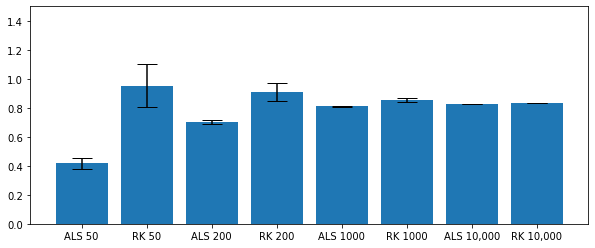

In [50]:
objects = ('ALS 50', 'RK 50', 'ALS 200', 'RK 200', 'ALS 1000', 'RK 1000', 'ALS 10,000', 'RK 10,000')
y_pos = np.arange(len(objects))
performance = [np.mean(alserr1), np.mean(rkerr1), np.mean(alserr2), np.mean(rkerr2), np.mean(alserr3), np.mean(rkerr3), np.mean(alserr4), np.mean(rkerr4)]
plt.figure(figsize=(10,4))
plt.bar(y_pos, performance, yerr=[np.std(alserr1), np.std(rkerr1), np.std(alserr2), np.std(rkerr2), np.std(alserr3), np.std(rkerr3), np.std(alserr4), np.std(rkerr4)], 
        ecolor='black', capsize=10)
plt.xticks(y_pos, objects)
plt.ylim([0, 1.5]) 
plt.show()

## Greatly Overdetermined Tests (Dense)

### 50x50 matrix

In [51]:
factor1d = np.random.choice(4, size=(50,4))
weight1d = np.random.randint(1, 5, size=(4, 50))
X1d = np.matmul(factor1d, weight1d)

In [52]:
%%time
n = 15
data = X1d
alserr1d = np.empty(n)

for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserr1d[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserr1d)

[0.26919336 0.31211605 0.36041857 0.26810103 0.27703596 0.35269183
 0.36224166 0.34093271 0.48529221 0.36384362 0.36114928 0.344258
 0.32283466 0.46717681 0.42165737]
Wall time: 323 ms


In [53]:
%%time
n = 15
data = X1d
rkerr1d = np.empty(n)

for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerr1d[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerr1d)

[0.81218012 0.68973852 0.61087044 0.78047049 0.72037832 0.76372617
 0.85369566 0.77390554 0.66757133 0.63096742 0.97024075 0.83625636
 0.79793571 0.65385594 0.62201971]
Wall time: 3min 21s


### 200x200 matrix

In [54]:
factor2d = np.random.choice(4, size=(200,4))
weight2d = np.random.randint(1, 5, size=(4, 200))
X2d = np.matmul(factor2d, weight2d)

In [55]:
%%time
n = 15
data = X2d
alserr2d = np.empty(n)

for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserr2d[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserr2d)

[0.73335688 0.7255293  0.67944945 0.68387367 0.65899718 0.72742631
 0.70136524 0.71826202 0.71990538 0.67072783 0.73231285 0.74333174
 0.65796337 0.6746601  0.76357803]
Wall time: 461 ms


In [56]:
%%time
n = 15
data = X2d
rkerr2d = np.empty(n)
for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerr2d[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerr2d)

[1.16548678 1.22028958 1.02947021 1.04043752 1.20341712 1.04525389
 1.15574432 1.24619767 1.18676101 1.17861912 1.13875784 1.77772691
 1.01491292 1.0590455  1.04024414]
Wall time: 5min 5s


### 1000x1000 matrix

In [57]:
factor3d = np.random.choice(4, size=(1000,4))
weight3d = np.random.randint(1, 5, size=(4, 1000))
X3d = np.matmul(factor3d, weight3d)

In [58]:
%%time
n = 15
data = X3d
alserr3d = np.empty(n)

for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserr3d[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserr3d)

[0.90356081 0.89272188 0.91639242 0.89412506 0.88880184 0.89294893
 0.89461441 0.89449607 0.89598229 0.89283726 0.8917909  0.88852199
 0.91589117 0.89439802 0.89675895]
Wall time: 16.1 s


In [59]:
%%time
n = 15
data = X3d
rkerr3d = np.empty(n)
for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerr3d[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerr3d)

[1.04853763 1.12535069 1.1330825  1.12545265 1.06745875 1.07797708
 1.09324832 1.10459652 1.05709152 1.11885871 1.07508778 1.17004811
 1.03461104 1.14257544 1.1365171 ]
Wall time: 12min 30s


### 10,000x10,000 matrix

In [60]:
factor4d = np.random.choice(4, size=(10000,4))
weight4d = np.random.randint(1, 5, size=(4, 10000))
X4d = np.matmul(factor4d, weight4d)

In [61]:
%%time
n = 15
data = X4d
alserr4d = np.empty(n)

for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserr4d[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserr4d)

[0.93999817 0.94042158 0.93996403 0.94071111 0.93998706 0.939965
 0.94024521 0.93963169 0.93997109 0.93981265 0.93984502 0.94057808
 0.93957449 0.94003627 0.94016098]
Wall time: 27min 1s


In [62]:
%%time
n = 15
data = X4d
rkerr4d = np.empty(n)
for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerr4d[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerr4d)

[0.9528076  0.95201166 0.95089574 0.9516235  0.95169277 0.95083084
 0.94951602 0.94949721 0.95078475 0.94818882 0.94977897 0.95515993
 0.95094816 0.94876926 0.95061598]
Wall time: 2h 25min 46s


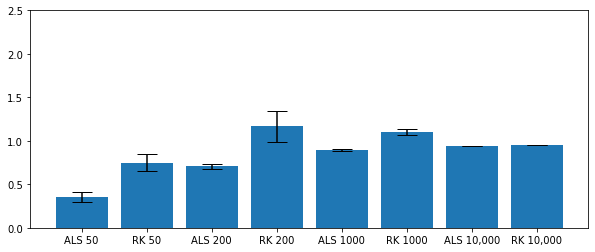

In [63]:
objects = ('ALS 50', 'RK 50', 'ALS 200', 'RK 200', 'ALS 1000', 'RK 1000', 'ALS 10,000', 'RK 10,000')
y_pos = np.arange(len(objects))
performance = [np.mean(alserr1d), np.mean(rkerr1d), np.mean(alserr2d), np.mean(rkerr2d), np.mean(alserr3d), np.mean(rkerr3d), np.mean(alserr4d), np.mean(rkerr4d)]
plt.figure(figsize=(10,4))
plt.bar(y_pos, performance, yerr=[np.std(alserr1d), np.std(rkerr1d), np.std(alserr2d), np.std(rkerr2d), np.std(alserr3d), np.std(rkerr3d), np.std(alserr4d), np.std(rkerr4d)], 
        ecolor='black', capsize=10)
plt.xticks(y_pos, objects)
plt.ylim([0, 2.5]) 
plt.show()

## Super Sparse

In [6]:
test = np.matmul(np.random.choice(4, size=(1000,4), p=np.array([0.94, 0.02, 0.02, 0.02])), np.random.randint(0, 2, size=(4, 1000)))
np.count_nonzero(test == 0) / (1000*1000)

0.889889

In [17]:
%%time
n = 15
data = test
alserrtest = np.empty(n)
for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserrtest[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserrtest)

[1.41767704 1.41741776 1.40640872 1.38784354 1.42299575 1.40914544
 1.41219513 1.4416774  1.42332946 1.41833354 1.42236316 1.41806909
 1.41490143 1.39727654 1.41095161]
Wall time: 16.2 s


In [18]:
%%time
n = 15
data = test
rkerrtest = np.empty(n)
for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerrtest[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerrtest)

[1.56319089 1.53041325 1.5104354  1.53862157 1.49828677 1.54554063
 1.55122476 1.53123771 1.52125136 1.5579253  1.57570971 1.54469943
 1.54138176 1.53780933 1.53830171]
Wall time: 12min 50s


In [19]:
test = np.matmul(np.random.choice(4, size=(10000,4), p=np.array([0.94, 0.02, 0.02, 0.02])), np.random.randint(0, 2, size=(4, 10000)))
np.count_nonzero(test == 0) / (10000*10000)

0.88413794

In [20]:
%%time
n = 15
data = test
alserrtest2 = np.empty(n)
for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserrtest2[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserrtest2)

[1.44683716 1.45924798 1.44750989 1.44250782 1.45421348 1.46163491
 1.44769073 1.4558043  1.448736   1.4494684  1.44710154 1.45006682
 1.45160295 1.45729113 1.45083739]
Wall time: 27min 10s


In [21]:
%%time
n = 15
data = test
rkerrtest2 = np.empty(n)
for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerrtest2[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerrtest2)

[1.46040304 1.47093681 1.46328942 1.46000799 1.48356481 1.47001669
 1.4646682  1.4630324  1.47431414 1.47220746 1.46073747 1.46283854
 1.46746385 1.46945837 1.4734911 ]
Wall time: 2h 52min 40s
